In [1]:
# Import packages
%matplotlib inline 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display, HTML

# Set default Seaborn style
sns.set()

In [2]:
# File path
food_business_file = 'Dataset/food_business.csv'

In [3]:
# Read in data as DataFrame
food_business = pd.read_csv(food_business_file)

In [4]:
# Change postal datatype to string
food_business['postal_code'] = food_business['postal_code'].apply(lambda p: str(p) if np.isnan(p) else str(int(p)))

# Overall info
display(food_business.info())
display(food_business.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33289 entries, 0 to 33288
Data columns (total 10 columns):
business_id     33289 non-null object
name            33289 non-null object
attributes      32589 non-null object
city            33289 non-null object
state           33289 non-null object
categories      33289 non-null object
stars           33289 non-null float64
review_count    33289 non-null int64
postal_code     33289 non-null object
population      33289 non-null int64
dtypes: float64(1), int64(2), object(7)
memory usage: 2.5+ MB


None

(33289, 10)

In [5]:
# Substract food businesses that are in Las Vegas
las_vegas = food_business.loc[food_business['city'] == 'Las Vegas']
display(las_vegas.shape)
food_df = food_business[~food_business.isin(las_vegas)].dropna(how='all')
display(food_df.shape)

(5965, 10)

(27324, 10)

In [6]:
import random

# Function to label good food businesses based on assumed conditions 
def label_businesses(group, sample_size):
    # Get the size of the dataframe
    n = len(group)
    # Randomly select 50 rows to label
    rows = random.sample(range(0,n+1), sample_size)
    labeled_group = group.reset_index(drop=True).iloc[rows]
    labeled_group.sort_index(inplace=True)
    # Apply log to reduce skewness
    log_mean = np.mean(np.log(group['review_count']))
    log_std = np.std(np.log(group['review_count']))
    # Set range for review count
    lower = np.exp(log_mean - log_std)
    upper = np.exp(log_mean + log_std)
    print("Lower bound = {} and upper bound = {}".format(lower, upper))
    # Label businesses
    labeled_group['good'] = np.where((labeled_group['stars'] >= 4) & (labeled_group['review_count'] >= lower) & (labeled_group['review_count'] <= upper), 1, 0)
    
    return labeled_group

In [7]:
# Unsupervised approach
from sklearn.cluster import KMeans,SpectralClustering, AgglomerativeClustering
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import silhouette_score

# Function to find the best n_clusters 
def find_best_k(clf, X, k_range=range(2,9)):
    best_score = -np.inf

    for k in k_range:
        clf = clf.set_params(n_clusters=k)
        labels = clf.fit_predict(X)
        silhouette_avg = silhouette_score(X, labels)
        print("For K: {:d}, the average Silhouette score: {}".format(k, silhouette_avg))

        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_k = k

    print("The best K: {:d} with score: {}".format(best_k, best_score))
    return best_k, best_score
    

In [14]:
# KMeans
sampled_rows = random.sample(range(0,len(food_df)+1), 250)
food_ob = food_df.copy().iloc[sampled_rows]
food_ob.sort_index(inplace=True)
X_food = food_ob[['review_count','population','stars']]
kmeans_food = KMeans()
k, score = find_best_k(kmeans_food, X_food)

For K: 2, the average Silhouette score: 0.775667322988
For K: 3, the average Silhouette score: 0.77246941725
For K: 4, the average Silhouette score: 0.81157843649
For K: 5, the average Silhouette score: 0.834866131949
For K: 6, the average Silhouette score: 0.821379311992
For K: 7, the average Silhouette score: 0.81840777172
For K: 8, the average Silhouette score: 0.809602265262
The best K: 5 with score: 0.834866131949


In [15]:
kmeans_food = KMeans(n_clusters=k)
food_ob.loc[:,'cluster_label'] = kmeans_food.fit_predict(X_food)

In [16]:
display(food_ob.groupby('cluster_label')[['review_count','stars']].describe())
display(food_ob.groupby('cluster_label')['population'].describe())

review_count                                                    \
                     count        mean         std  min    25%   50%     75%   
cluster_label                                                                  
0                     79.0   94.151899  146.853589  3.0  11.00  36.0   98.00   
1                     31.0  134.612903  341.734368  6.0  13.50  37.0   91.50   
2                     31.0   93.354839  108.265891  5.0  12.50  47.0  147.00   
3                     88.0   33.011364   39.711458  3.0   6.75  16.5   45.75   
4                     21.0   77.000000  137.634661  3.0   5.00  14.0   76.00   

                      stars                                                
                  max count      mean       std  min  25%  50%   75%  max  
cluster_label                                                              
0               771.0  79.0  3.582278  0.878629  1.0  3.0  4.0  4.00  5.0  
1              1867.0  31.0  3.387097  1.022331  1.5  2.5  3.5  4.00  5.0  
2               349.0  31.0  3.645161  0.797847  1.5  3.0  4.0  4.25  5.0  
3               205.0  88.0  3.568182  0.878157  1.0  3.0  3.5  4.00  5.0  
4               535.0  21.0  3.571429  1.075706  1.0  3.0  4.0  4.50  5.0

,count,mean,std,min,25%,50%,75%,max
cluster_label,,,,,,,,
0,79.0,2.562049e+05,39259.649526,168181.0,246709.0,249950.0,302407.00,302539.0
1,31.0,1.626078e+06,0.000000,1626078.0,1626078.0,1626078.0,1626078.00,1626078.0
2,31.0,8.590350e+05,0.000000,859035.0,859035.0,859035.0,859035.00,859035.0
3,88.0,2.980600e+04,29251.772168,607.0,6880.0,18172.0,45338.25,134085.0
4,21.0,4.383231e+05,56742.602022,385525.0,385525.0,385525.0,496401.00,496401.0


0    79
1    31
2    31
3    88
4    21
dtype: int64


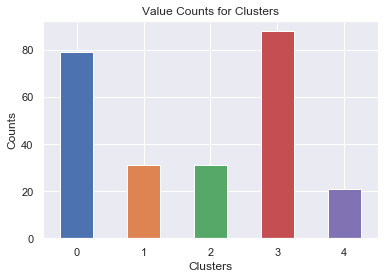

In [17]:
# Get value counts of each cluster
cluster_dist_food = pd.Series(kmeans_food.labels_).value_counts().sort_index()
print(cluster_dist_food)
# Bar plot
_ = cluster_dist_food.plot(kind='bar')
_ = plt.xlabel('Clusters')
_ = plt.ylabel('Counts')
_ = plt.xticks(rotation='horizontal')
_ = plt.title('Value Counts for Clusters')

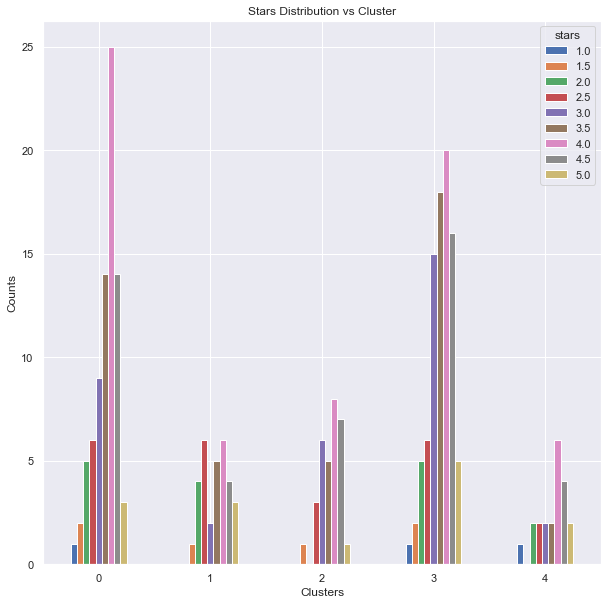

In [18]:
# Bar plot relationship between cluster and stars
pd.crosstab(food_ob['cluster_label'], food_ob['stars']).plot(kind='bar', figsize=(10,10), rot='horizontal')
_ = plt.xlabel('Clusters')
_ = plt.ylabel('Counts')
_ = plt.title('Stars Distribution vs Cluster')

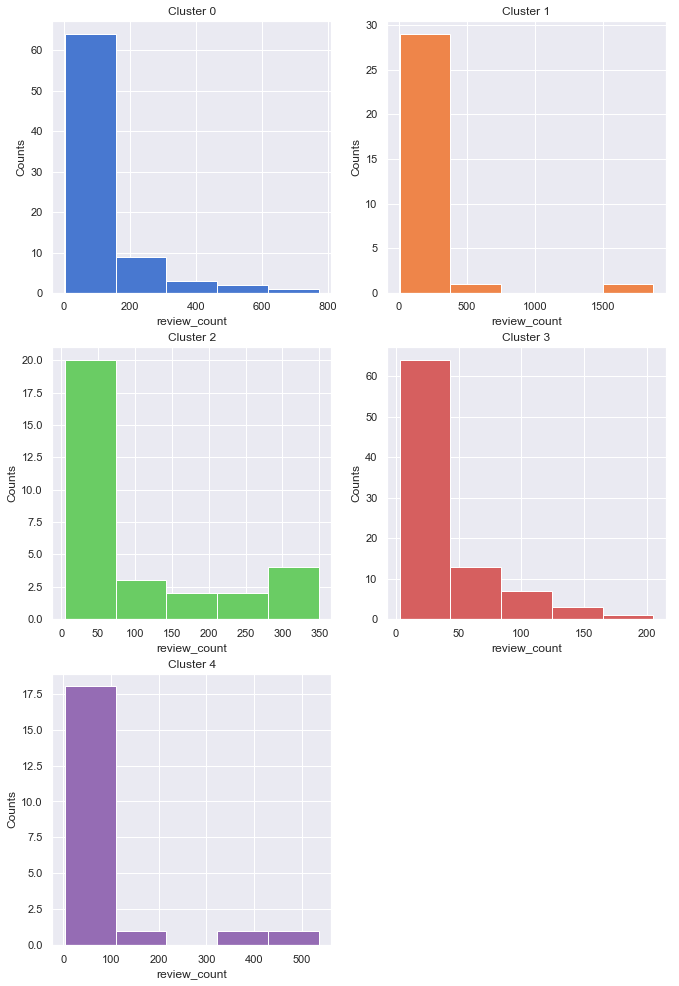

In [20]:
# Histogram plot realtionship between cluster and review count
fig, axes = plt.subplots(3,2, figsize=(11,17))
colors = sns.color_palette("muted", n_colors=5)
# Cluster 0
food_ob.loc[food_ob['cluster_label']==0]['review_count'].hist(ax=axes[0,0], bins=5, color=colors[0])
#_ = axes[0,0].set_yticks(np.arange(0,23,2))
_ = axes[0,0].set_xlabel('review_count')
_ = axes[0,0].set_ylabel('Counts')
_ = axes[0,0].set_title('Cluster 0')
# Cluster 1
food_ob.loc[food_ob['cluster_label']==1]['review_count'].hist(ax=axes[0,1], bins=5, color=colors[1])
#_ = axes[0,1].set_yticks(np.arange(0,61,5))
_ = axes[0,1].set_xlabel('review_count')
_ = axes[0,1].set_ylabel('Counts')
_ = axes[0,1].set_title('Cluster 1')
# Cluster 2
food_ob.loc[food_ob['cluster_label']==2]['review_count'].hist(ax=axes[1,0], bins=5, color=colors[2])
#_ = axes[1,0].set_yticks(np.arange(0,86,5))
_ = axes[1,0].set_xlabel('review_count')
_ = axes[1,0].set_ylabel('Counts')
_ = axes[1,0].set_title('Cluster 2')
# Cluster 3
food_ob.loc[food_ob['cluster_label']==3]['review_count'].hist(ax=axes[1,1], bins=5, color=colors[3])
_ = axes[1,1].set_xlabel('review_count')
_ = axes[1,1].set_ylabel('Counts')
_ = axes[1,1].set_title('Cluster 3')
# Cluster 4
food_ob.loc[food_ob['cluster_label']==4]['review_count'].hist(ax=axes[2,0], bins=5, color=colors[4])
#_ = axes[2,0].set_yticks(np.arange(0, 25,2))
_ = axes[2,0].set_xlabel('review_count')
_ = axes[2,0].set_ylabel('Counts')
_ = axes[2,0].set_title('Cluster 4')
# Remove unused ax
axes[2,1].remove()

In [34]:
num_clusters = k
ks_ob = []
scores_ob = []

# Find best k for each cluster
for i in range(0, num_clusters):
    print('Cluster {:d}:'.format(i))
    X_ob = food_ob.loc[food_ob['cluster_label'] == i][['review_count', 'stars']]
    kmeans_ob = KMeans()
    k_ob, score_ob = find_best_k(kmeans_ob, X_ob)
    ks_ob.append(k_ob)
    scores_ob.append(score_ob)

Cluster 0:
For K: 2, the average Silhouette score: 0.778506698046
For K: 3, the average Silhouette score: 0.741240414953
For K: 4, the average Silhouette score: 0.691484606837
For K: 5, the average Silhouette score: 0.640550693601
For K: 6, the average Silhouette score: 0.654959745707
For K: 7, the average Silhouette score: 0.663253439484
For K: 8, the average Silhouette score: 0.631544626676
The best K: 2 with score: 0.778506698046
Cluster 1:
For K: 2, the average Silhouette score: 0.910310240597
For K: 3, the average Silhouette score: 0.796841039073
For K: 4, the average Silhouette score: 0.724899734705
For K: 5, the average Silhouette score: 0.678325677071
For K: 6, the average Silhouette score: 0.639472874545
For K: 7, the average Silhouette score: 0.55042479696
For K: 8, the average Silhouette score: 0.55224928503
The best K: 2 with score: 0.910310240597
Cluster 2:
For K: 2, the average Silhouette score: 0.755009445432
For K: 3, the average Silhouette score: 0.73702741631
For K: 4

In [35]:
for i in range(0, num_clusters):
    X_ob = food_ob.loc[food_ob['cluster_label'] == i][['review_count', 'stars']]
    kmeans_ob = KMeans(n_clusters=ks_ob[i])
    food_ob.loc[food_ob['cluster_label'] == i, 'cluster_label_2'] = kmeans_ob.fit_predict(X_ob)

In [36]:
display(food_ob.groupby(['cluster_label','cluster_label_2'])[['review_count','stars']].describe())

review_count                                   \
                                     count         mean         std     min   
cluster_label cluster_label_2                                                 
0             0.0                     68.0    44.455882   48.415007     3.0   
              1.0                     11.0   401.363636  178.602504   225.0   
1             0.0                     30.0    76.866667  117.776449     6.0   
              1.0                      1.0  1867.000000         NaN  1867.0   
2             0.0                     23.0    35.869565   35.826989     5.0   
              1.0                      8.0   258.625000   64.240480   155.0   
3             0.0                     67.0    14.343284   12.108790     3.0   
              1.0                     21.0    92.571429   38.520866    57.0   
4             0.0                     19.0    35.684211   40.647608     3.0   
              1.0                      2.0   469.500000   92.630988   404.0   

                                                                stars  \
                                   25%     50%      75%     max count   
cluster_label cluster_label_2                                           
0             0.0                 9.00    23.5    66.25   201.0  68.0   
              1.0               264.50   315.0   505.00   771.0  11.0   
1             0.0                12.25    35.5    77.00   583.0  30.0   
              1.0              1867.00  1867.0  1867.00  1867.0   1.0   
2             0.0                11.00    22.0    47.50   139.0  23.0   
              1.0               225.25   276.0   291.50   349.0   8.0   
3             0.0                 4.50    10.0    18.00    51.0  67.0   
              1.0                62.00    87.0    95.00   205.0  21.0   
4             0.0                 5.00    13.0    58.00   127.0  19.0   
              1.0               436.75   469.5   502.25   535.0   2.0   

                                                                            \
                                   mean       std  min    25%   50%    75%   
cluster_label cluster_label_2                                                
0             0.0              3.514706  0.910021  1.0  3.000  3.75  4.000   
              1.0              4.000000  0.500000  3.0  3.750  4.00  4.500   
1             0.0              3.366667  1.033352  1.5  2.500  3.50  4.000   
              1.0              4.000000       NaN  4.0  4.000  4.00  4.000   
2             0.0              3.500000  0.852803  1.5  3.000  3.50  4.000   
              1.0              4.062500  0.417261  3.5  3.875  4.00  4.500   
3             0.0              3.455224  0.940387  1.0  3.000  3.50  4.000   
              1.0              3.928571  0.507093  2.5  3.500  4.00  4.500   
4             0.0              3.500000  1.105542  1.0  2.750  4.00  4.250   
              1.0              4.250000  0.353553  4.0  4.125  4.25  4.375   

                                    
                               max  
cluster_label cluster_label_2       
0             0.0              5.0  
              1.0              4.5  
1             0.0              5.0  
              1.0              4.0  
2             0.0              5.0  
              1.0              4.5  
3             0.0              5.0  
              1.0              4.5  
4             0.0              5.0  
              1.0              4.5

stars                          1.0  1.5  2.0  2.5  3.0  3.5  4.0  4.5  5.0
cluster_label cluster_label_2                                             
0             0.0                1    2    5    6    8   12   21   10    3
              1.0                0    0    0    0    1    2    4    4    0
1             0.0                0    1    4    6    2    5    5    4    3
              1.0                0    0    0    0    0    0    1    0    0
2             0.0                0    1    0    3    6    3    5    4    1
              1.0                0    0    0    0    0    2    3    3    0
3             0.0                1    2    5    5   15   12   12   10    5
              1.0                0    0    0    1    0    6    8    6    0
4             0.0                1    0    2    2    2    2    5    3    2
              1.0                0    0    0    0    0    0    1    1    0

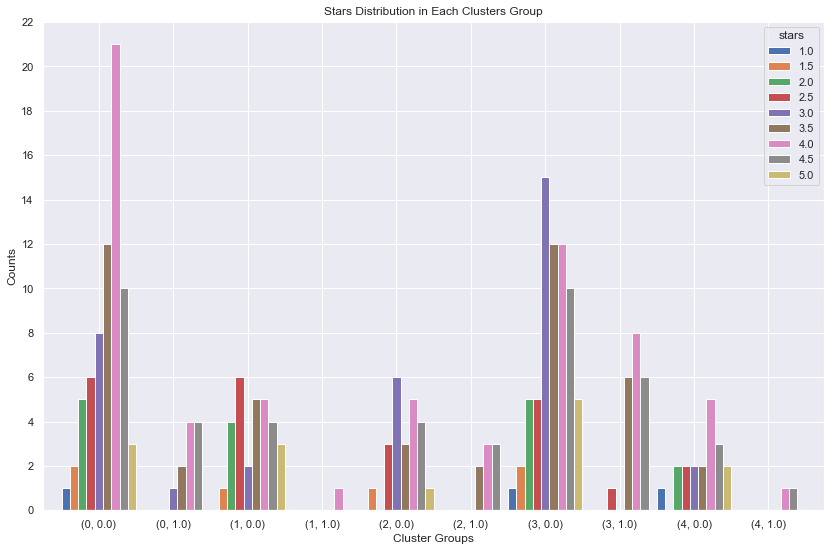

In [60]:
display(pd.crosstab([food_ob.cluster_label,food_ob.cluster_label_2], food_ob.stars))
pd.crosstab([food_ob.cluster_label,food_ob.cluster_label_2], food_ob.stars).plot(kind='bar', figsize=(14,9), rot='horizontal', width=1)
_ = plt.title('Stars Distribution in Each Clusters Group')
_ = plt.xlabel('Cluster Groups')
_ = plt.ylabel('Counts')
_ = plt.yticks(np.arange(0, 23, 2))

In [62]:
# Spectral Clustering
sampled_rows = random.sample(range(0,len(food_df)+1), 250)
food_sc = food_df.copy().iloc[sampled_rows]
food_sc.sort_index(inplace=True)
sc = SpectralClustering()
X_food = food_sc[['review_count','population','stars']]
k_sc, score_sc = find_best_k(sc, X_food)

For K: 2, the average Silhouette score: -0.482199235928
For K: 3, the average Silhouette score: -0.486384255389
For K: 4, the average Silhouette score: -0.472433915077
For K: 5, the average Silhouette score: -0.480100536172
For K: 6, the average Silhouette score: -0.480100536172

C:\Users\supengwen\Miniconda2\envs\cp1\lib\site-packages\sklearn\cluster\spectral.py:268: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  n_init=n_init)
C:\Users\supengwen\Miniconda2\envs\cp1\lib\site-packages\sklearn\cluster\spectral.py:268: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  n_init=n_init)



For K: 7, the average Silhouette score: -0.480100536172
For K: 8, the average Silhouette score: -0.480100536172
The best K: 4 with score: -0.472433915077


C:\Users\supengwen\Miniconda2\envs\cp1\lib\site-packages\sklearn\cluster\spectral.py:268: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  n_init=n_init)


In [63]:
# Agglomerative Clustering
sampled_rows = random.sample(range(0,len(food_df)+1), 250)
food_ac = food_df.copy().iloc[sampled_rows]
food_ac.sort_index(inplace=True)
ac = AgglomerativeClustering()
X_food = food_sc[['review_count','population','stars']]
k_ac, score_ac = find_best_k(ac, X_food)

For K: 2, the average Silhouette score: 0.779620924211
For K: 3, the average Silhouette score: 0.782375467831
For K: 4, the average Silhouette score: 0.801392621431
For K: 5, the average Silhouette score: 0.808151901224
For K: 6, the average Silhouette score: 0.806290284338
For K: 7, the average Silhouette score: 0.757516906658
For K: 8, the average Silhouette score: 0.821134069437
The best K: 8 with score: 0.821134069437


In [64]:
ac = AgglomerativeClustering(n_clusters=k_ac)
food_ac.loc[:,'cluster_label'] = ac.fit_predict(X_food)

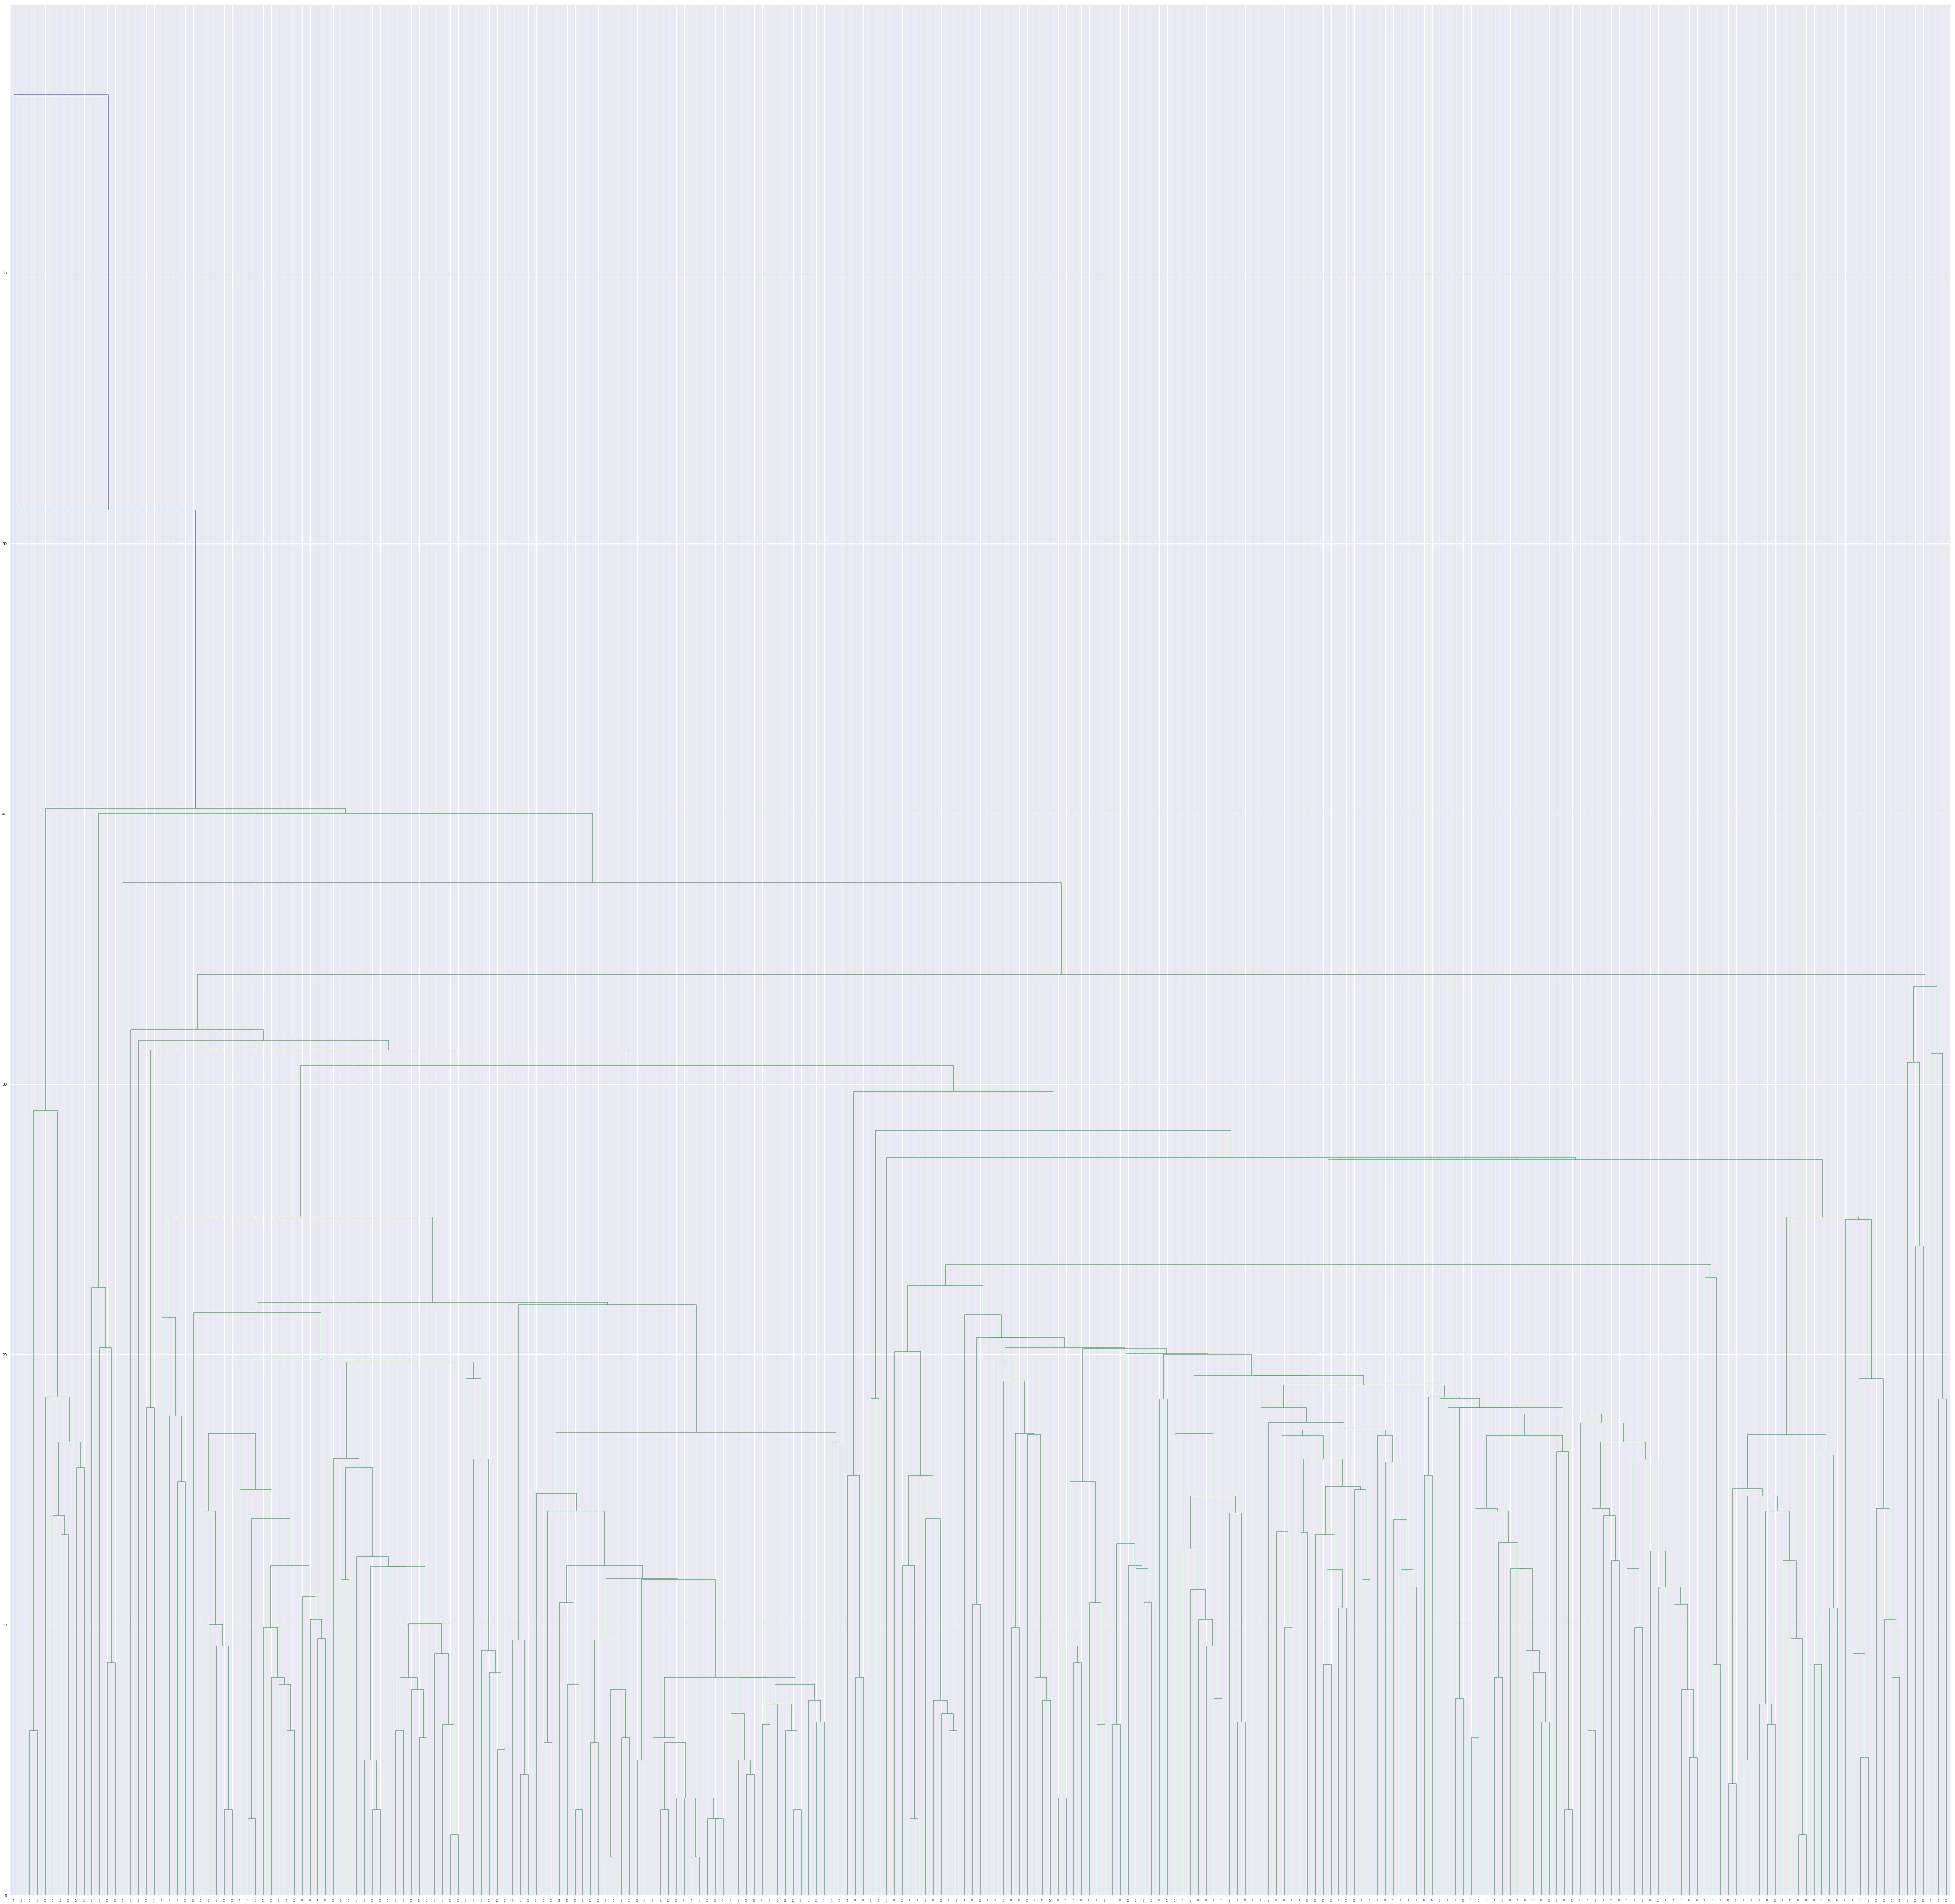

In [75]:
from scipy.cluster.hierarchy import dendrogram, linkage

fig_ac, ax_ac = plt.subplots(1,1, figsize=(100,100))
dendrogram(linkage(ac.children_), ax=ax_ac)
plt.show()

In [ ]:
# Split food_df into five groups
first , second, third, fourth, fifth = np.percentile(food_df.population, [20,40,60,80,100])
first_group = food_df.loc[food_df.population <= first]
second_group = food_df.loc[(food_df.population > first) & (food_df.population <= second)]
third_group = food_df.loc[(food_df.population > second) & (food_df.population <= third)]
fourth_group = food_df.loc[(food_df.population > third) & (food_df.population <= fourth)]
fifth_group = food_df.loc[(food_df.population > fourth) & (food_df.population <= fifth)]
display(first_group.describe())
display(second_group.describe())
display(third_group.describe())
display(fourth_group.describe())
display(fifth_group.describe())

In [ ]:
# Label 50 businesses in each group for observation and training purpose
n_sample = 50
labeled_first = label_businesses(first_group, n_sample)
labeled_second = label_businesses(second_group, n_sample)
labeled_third = label_businesses(third_group, n_sample)
labeled_fourth = label_businesses(fourth_group, n_sample)
labeled_fifth = label_businesses(fifth_group, n_sample)

In [ ]:
#X = labeled_first['review_count'].values.reshape(-1, 1)
X = labeled_first[['review_count','stars']]
find_best_k(X)

In [ ]:
kmeans = KMeans(n_clusters=best_k)
labels = kmeans.fit_predict(X)
labeled_first['cluster_label'] = labels
display(labeled_first.head())

In [ ]:
# Get value counts of each cluster
cluster_dist = pd.Series(labels).value_counts().sort_index()
print(cluster_dist)
# Bar plot
_ = cluster_dist.plot(kind='bar')
_ = plt.xlabel('Clusters')
_ = plt.ylabel('Counts')
_ = plt.xticks(rotation='horizontal')
_ = plt.title('Value Counts for Clusters')

In [ ]:
display(labeled_first.groupby('cluster_label')[['review_count','stars']].describe())
display(labeled_first.groupby('cluster_label')[['review_count','good']].describe())

In [ ]:
labeled_first.drop(columns=['cluster_label'], inplace=True)
labeled_df = pd.concat([labeled_first, labeled_second, labeled_third, labeled_fourth, labeled_fifth])
labeled_df.sort_index(inplace=True)
display(labeled_df.info())

In [ ]:
# Find the best n_clusters for full set
#X_f = labeled_df['review_count'].values.reshape(-1, 1)
#X_f = labeled_df[['review_count','stars']]
X_f = labeled_df[['review_count','stars','population']]
best_score_f = -np.inf

for k in ks:
    kmeans_f = KMeans(n_clusters=k)
    labels_f = kmeans.fit_predict(X_f)
    silhouette_avg = silhouette_score(X_f, labels_f)
    print("For K: {:d}, the average Silhouette score: {}".format(k, silhouette_avg))
    
    if silhouette_avg > best_score_f:
        best_score_f = silhouette_avg
        best_k_f = k

print("The best K: {:d} with score: {}".format(best_k_f, best_score_f))

In [ ]:
kmeans_f = KMeans(n_clusters=best_k_f)
labels_f = kmeans_f.fit_predict(X_f)
labeled_df['cluster_label'] = labels_f
display(labeled_df.head())

In [ ]:
# Get value counts of each cluster
cluster_dist_f = pd.Series(labels_f).value_counts().sort_index()
print(cluster_dist_f)
# Bar plot
_ = cluster_dist_f.plot(kind='bar')
_ = plt.xlabel('Clusters')
_ = plt.ylabel('Counts')
_ = plt.xticks(rotation='horizontal')
_ = plt.title('Value Counts for Clusters')

In [ ]:
display(labeled_df.groupby('cluster_label')[['review_count','stars']].describe())
display(labeled_df.groupby('cluster_label')[['population','good']].describe())

In [ ]:
# Supervised appraoch

In [ ]:
cv_result = cross_validate(kmeans, X, cv=10, return_train_score=True, return_estimator=True, error_score=np.nan)
print(cv_result.keys())
print(cv_result['test_score'])
print(cv_result['train_score'])